In [1]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import os.path
import time, itertools, re
from collections import Counter
from sklearn.inspection import permutation_importance
import miceforest as mf
from sklearn.metrics import confusion_matrix, r2_score, root_mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegressionCV, LassoCV
import importlib
import pickle
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
print(os.getcwd())
fileloc_data='/'.join(os.getcwd().split('/')[0:5])+ '/data/annonymizedDatasets/'
savetag='pred_lavSQ_MHC'
print(fileloc_data)
code_path='/'.join(os.getcwd().split('/')[0:4])+'/sklvq/'
sys.path.append(code_path)
from sklvq import GMLVQ, LGMLVQ
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis,)
from sklearn.svm import SVC, SVR
from EDdataset_GGZ import colsTypeCast  
from HypOpt import lowest_cwacc
df_all_combo=pd.read_csv(fileloc_data+'maskedDAIsy_MainDect_ED_SQ48_MHC_Honos_Lav.tsv', sep='\t', decimal=',')
df_adapted_combo, colsExtracted, subscales=colsTypeCast(df_all_combo)
adapted_combo_cols=np.setdiff1d(colsExtracted,
        ['ED_Codes','EDtype', 'SQ48-Score', 'MHCSF-Score', 'Lav-Score']+list(subscales['Honos'])+list(subscales['EDEQ']))
print(adapted_combo_cols)

/home/sreejita/anaconda3/envs/py_env1/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


/home/sreejita/ProjectsPy/GGZ/code_scripts/ED-profiling
/home/sreejita/ProjectsPy/GGZ/data/annonymizedDatasets/
['DT-BMI' 'DT-Disorder_Duration_Yrs' 'DT-IND_BDL_CMD' 'DT-IND_OCD_CMD'
 'DT-IND_depression_CMD' 'DT-IND_others' 'DT-IND_prev_spec_int_wo_eff'
 'DT-num_prev_routes' 'Lav-Dissatisfaction_body'
 'Lav-Negative_appraisal_body' 'Lav-Unfamiliarity_with_body'
 'MHCSF-Emotional_Well-being' 'MHCSF-Psychological_Well-being'
 'MHCSF-Social_Well-being' 'Main-Age' 'Main-Biosex' 'Main-Education'
 'SQ48-Agoraphobia' 'SQ48-Anxiety' 'SQ48-Cognitive_Complaints'
 'SQ48-Depression' 'SQ48-Hostility' 'SQ48-Social_phobia'
 'SQ48-Somatic_Complaints' 'SQ48-Vitality' 'SQ48-Work_related_complaints']


In [2]:
%load_ext autoreload

# Classification

## All classes

In [3]:
df_train_adapted=df_adapted_combo[adapted_combo_cols].loc[df_adapted_combo['Split']=='Train']
YTrain=df_adapted_combo['EDtype'].loc[df_adapted_combo['Split']=='Train']#.to_numpy()
df_test_adapted=df_adapted_combo[adapted_combo_cols].loc[df_adapted_combo['Split']=='Test']
YTest=df_adapted_combo['EDtype'].loc[df_adapted_combo['Split']=='Test']#.to_numpy()
sampling_strategy='not majority'

nan_mean=np.nanmean(df_train_adapted.to_numpy(), axis=0)
nan_std=np.nanstd(df_train_adapted.to_numpy(), axis=0)
z_train_explore_nan=((df_train_adapted.to_numpy()-nan_mean)/nan_std)
z_test_df=pd.DataFrame(data=((df_test_adapted.to_numpy()-nan_mean)/nan_std), columns=adapted_combo_cols)
z_train_df=pd.DataFrame(data=z_train_explore_nan, columns=adapted_combo_cols)

kernel_mean_match = mf.ImputationKernel(data=z_train_df,num_datasets=1,mean_match_candidates=5)
kernel_mean_match.mice(10)
z_train_explore=pd.DataFrame(data=kernel_mean_match.complete_data(), columns=adapted_combo_cols)
temp_test=kernel_mean_match.impute_new_data(z_test_df)
z_test_explore=pd.DataFrame(data=temp_test.complete_data(), columns=adapted_combo_cols)
sm=SMOTE(sampling_strategy=sampling_strategy)
X,Y=sm.fit_resample(z_train_explore, YTrain)

In [90]:
iters=5
savepicklpath='%s/pickles/'%(os.getcwd())
dataset_type='Core_DT'
model_fname='cls-%s.pkl'%dataset_type
modelsClassify1='%s%s'%(savepicklpath, model_fname)
modelsClassify1_permut='%s%s_%s'%(savepicklpath,dataset_type, 'permImp')
print(modelsClassify1)
print(modelsClassify1_permut)
if os.path.exists(modelsClassify1):
    pipeClassifiers = pickle.load(open(modelsClassify1, "rb"))
    permut_model=pickle.load(open('%s.pkl'%modelsClassify1_permut, "rb"))
    print('Loading final 5-class Classification models complete')
else:
    g_num_prots, l_num_prots=np.array([2,2,2,1,1]), np.array([3,2,2,1,1])
    pipeRF=Pipeline(steps=[('RF', RandomForestClassifier(criterion="gini", min_samples_leaf=5,
                                                                n_estimators=300, max_features=10))])
    pipeKNN=Pipeline(steps=[('KNN', KNeighborsClassifier(n_neighbors=3,metric='cosine'))])
    pipeLDA=Pipeline(steps=[('LDA', LinearDiscriminantAnalysis(solver='eigen'))])
    pipeQDA=Pipeline(steps=[('QDA', QuadraticDiscriminantAnalysis(reg_param=0.01))])
    pipeLSVC=Pipeline(steps=[('LSVC', SVC(kernel="linear", C=10))])
    pipeRSVC=Pipeline(steps=[('RSVC', SVC(kernel='rbf', C=100, gamma=0.01))])
    pipeGMLVQ=Pipeline(steps=[('GMLVQ', GMLVQ(distance_type='adaptive-squared-euclidean', 
            prototype_n_per_class=g_num_prots, relevance_regularization=0.0,
            activation_type='swish',relevance_n_components=7, solver_type='lbfgs'))])
    pipeLGMLVQ=Pipeline(steps=[('LGMLVQ', LGMLVQ(distance_type='local-adaptive-squared-euclidean', 
            prototype_n_per_class=l_num_prots, solver_type='lbfgs',activation_type='identity',
            relevance_n_components=20, relevance_localization="class"))])    
    pipeGNB=Pipeline(steps=[('GNB', GaussianNB())])
    pipeLogLASSO=Pipeline(steps=[('LogLASSO',LogisticRegressionCV(Cs=[0.0001,0.001,0.01,0.1,1], solver='saga',
                    class_weight='balanced', cv=5,penalty='l1', scoring=make_scorer(lowest_cwacc)))])
    pipeClassifiers={'RF':pipeRF, 'KNN':pipeKNN, 'LDA':pipeLDA, 'QDA': pipeQDA, 'LSVC': pipeLSVC, 
                 'RSVC': pipeRSVC, 'LGMLVQ': pipeLGMLVQ, 'GMLVQ': pipeGMLVQ, 'GNB': pipeGNB,
                'LogLASSO':pipeLogLASSO}
    use_permutation_imp=['KNN','LDA','QDA','LSVC','RSVC']
    permut_model, nreps,10
    for key, clf in pipeClassifiers.items():
        clf_all, temp=[],{}
        for iter in range(iters):
            clf.fit(X, Y)
            clf_all.append(clf)
            if key in use_permutation_imp:
                permimp = permutation_importance(clf, X, Y, n_repeats=nreps, scoring=make_scorer(lowest_cwacc))
                temp[iter]=permimp.importances
        if key in use_permutation_imp:
            permut_model[key]=temp#importances=>shape (n_features, n_repeats)
        pipeClassifiers[key]=clf_all
    print('Training final 5-class Classification models complete')
    with open(modelsClassify1, 'wb') as f:  # open a text file
        pickle.dump(pipeClassifiers, f) 
    with open('%s.pkl'%modelsClassify1_permut, 'wb') as f:  # open a text file
        pickle.dump(permut_model, f) 
    print('Saving final 5-class Classification models complete')
nclasses=len(np.unique(YTrain))
labs=np.unique(YTrain)
train_conf_all, test_conf_all, classifiers_all={},{},{}

/home/sreejita/ProjectsPy/GGZ/code_scripts/ED-profiling/pickles/cls-Core_DT.pkl
/home/sreejita/ProjectsPy/GGZ/code_scripts/ED-profiling/pickles/Core_DT_permImp
Loading final 5-class Classification models complete


In [91]:
num_prototypes=np.sum(g_num_prots)
num_features, iters=df_train_adapted.shape[1],5
prots_lvq, fimp_all={},{}
for key, clf in pipeClassifiers.items():
    tr_cmap=np.zeros((nclasses, nclasses, iters))
    te_cmap=np.zeros((nclasses, nclasses, iters))
    if (key=='GMLVQ') | (key=='LGMLVQ'):    
        all_prots=np.zeros((clf[0][key].prototypes_.shape[0], num_features, iters))
    if (key=='LGMLVQ') | (key=='GNB'):
        all_ftr_vars=np.zeros((nclasses, num_features, iters))
    elif key in use_permutation_imp:
        all_ftr_vars=np.zeros((num_features,nreps, iters))    
    else:
        all_ftr_vars=np.zeros((num_features, iters))#rel_diag=np.diagonal(clf[iter][key].lambda_.T   
    for iter in range(iters):  
        if key=='GMLVQ':
            all_ftr_vars[:,iter]=np.diagonal(clf[iter][key].lambda_)
        elif key=='RF':
            all_ftr_vars[:,iter]=clf[iter][key].feature_importances_
        elif key=='LGMLVQ':
            cwRel=[]
            for x in range(nclasses): cwRel.append(np.diagonal(clf[iter][key].lambda_[x]))
            all_ftr_vars[:,:,iter]=cwRel
        elif (key=='GNB'):
            all_ftr_vars[:,:,iter]=clf[iter][key].var_
        elif key=='LogLASSO':
            all_ftr_vars[:,iter]=clf[iter][key].coef_[np.where(clf[iter][key].Cs_==clf[iter][key].C_)[0]]
        else:
            all_ftr_vars[:,:,iter]=permut_model[key][iter]
        if (key=='GMLVQ') | (key=='LGMLVQ'):    
            all_prots[:,:,iter]=clf[iter][key].prototypes_            
        train_pred_labs=clf[iter][key].predict(z_train_explore)
        test_pred_labs=clf[iter][key].predict(z_test_explore)
        tr_cmap[:,:,iter]=confusion_matrix(YTrain, train_pred_labs, normalize='true', labels=labs)
        te_cmap[:,:,iter]=confusion_matrix(YTest, test_pred_labs, normalize='true', labels=labs)
        train_conf_all[key], test_conf_all[key]=tr_cmap, te_cmap
    if key in ['GMLVQ','LGMLVQ']:
        prots_lvq[key]={'Mean': np.mean(all_prots,axis=2), 'Std': np.std(all_prots,axis=2),
                       'All':all_prots}
    if key in use_permutation_imp:
       # print(key, all_ftr_vars.shape)
        n_extended=all_ftr_vars.shape[1]* all_ftr_vars.shape[2]
        all_ftr_vars=np.reshape(all_ftr_vars,(num_features, n_extended))
       # print(all_ftr_vars.shape)
        fimp_all[key]={'Mean': np.mean(all_ftr_vars, axis=1), 'Std':np.std(all_ftr_vars, axis=1),
                      'All': all_ftr_vars}
    elif key in ['RF', 'GMLVQ','LogLASSO']:
        fimp_all[key]={'Mean': np.mean(all_ftr_vars, axis=1), 'Std':np.std(all_ftr_vars, axis=1),
                      'All': all_ftr_vars}
    else:
        for c in range(nclasses):
            fimp_all[key]={'Mean_C%d'%(c+1): np.mean(all_ftr_vars[c,:,:]),
                          'Std_C%d'%(c+1): np.std(all_ftr_vars[c,:,:]),
                          'All_C%d'%(c+1): all_ftr_vars}

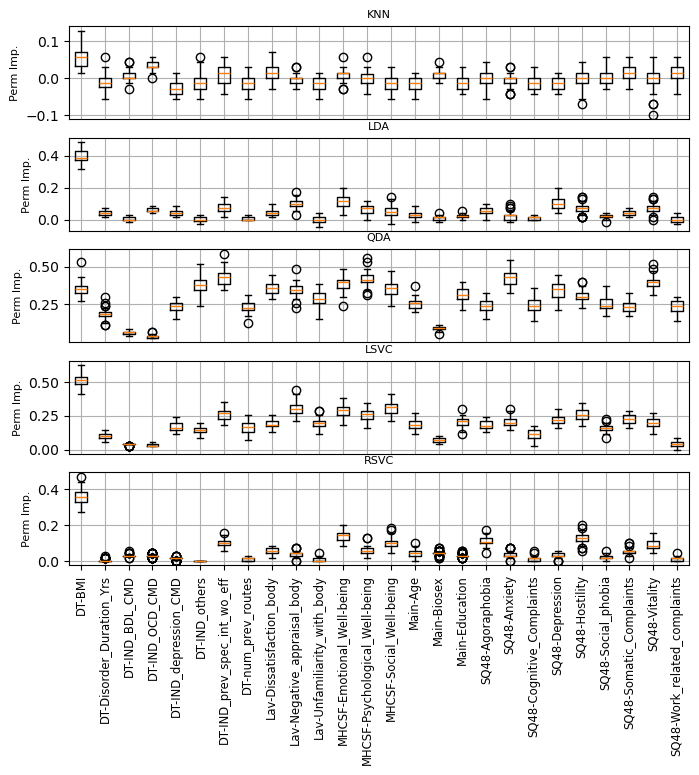

In [92]:
fig1,ax1=plt.subplots(len(use_permutation_imp),1, figsize=(8,7), sharex=True)
idx=0
for key, clf in pipeClassifiers.items():
    if key in use_permutation_imp:
        ax1[idx].boxplot(fimp_all[key]['All'].T)
        ax1[idx].set_title(key, fontsize=8)
        ax1[idx].set_ylabel('Perm Imp.', fontsize=8)
        ax1[idx].grid()
        if idx<len(use_permutation_imp)-1:
            ax1[idx].set_xticks([])
            ax1[idx].set_xticklabels([])
            ax1[idx].tick_params(bottom=False)
            idx+=1
        else:
            ax1[idx].set_xticks(list(range(1,num_features+1)))
            ax1[idx].set_xticklabels(df_train_adapted.columns, rotation=90, fontsize=7, size='small')
fig1.savefig('figs/PDFs/classification/C5_PermImp_%s.pdf'%dataset_type, bbox_inches='tight', transparent=False,
               pad_inches=0.01)
fig1.savefig('figs/PNGs/classification/C5_PermImp_%s.png'%dataset_type, bbox_inches='tight', transparent=True,
               pad_inches=0.01)

In [93]:
for key, clf in pipeClassifiers.items(): 
    cmap_dict={'Training': train_conf_all[key], 'Test':test_conf_all[key]}
    for split_set in ['Training', 'Test']:
        print(key+'-'+split_set)    
        if split_set=='Training':
            printlabs=[]
            for lab in labs:
                if (lab==labs[2]) | (lab==labs[4]):
                    printlabs.append('    '+lab)
                else:
                    printlabs.append(lab)
            print(printlabs)
        mean_glob, std_glob=cmap_dict[split_set].mean(axis=2), cmap_dict[split_set].std(axis=2)
        disp_num_glob=np.reshape(np.stack((mean_glob, std_glob)).ravel('F'),(nclasses,2*nclasses))
        for idx in range(nclasses):
            cmap_cell=[]
            for jdx in range(nclasses):
                cmap_cell.append('%.3f (%.3f) '%(mean_glob[idx,jdx], std_glob[idx,jdx]))
            print(cmap_cell) 

RF-Training
['Anorexia nervosa', 'Binge-ED', '    Bulimia nervosa', 'Other ED', '    Others']
['0.971 (0.000) ', '0.000 (0.000) ', '0.029 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ']
['0.000 (0.000) ', '0.950 (0.000) ', '0.050 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ']
['0.000 (0.000) ', '0.000 (0.000) ', '0.923 (0.000) ', '0.000 (0.000) ', '0.077 (0.000) ']
['0.059 (0.000) ', '0.059 (0.000) ', '0.000 (0.000) ', '0.882 (0.000) ', '0.000 (0.000) ']
['0.083 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ', '0.917 (0.000) ']
RF-Test
['0.500 (0.000) ', '0.062 (0.000) ', '0.062 (0.000) ', '0.062 (0.000) ', '0.312 (0.000) ']
['0.125 (0.000) ', '0.875 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ']
['0.000 (0.000) ', '0.333 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ', '0.667 (0.000) ']
['0.000 (0.000) ', '0.200 (0.000) ', '0.000 (0.000) ', '0.600 (0.000) ', '0.200 (0.000) ']
['0.000 (0.000) ', '0.333 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ', '0.667

## Only ED classes

In [94]:
df_train_eds=df_adapted_combo[adapted_combo_cols].loc[(df_adapted_combo['Split']=='Train') & 
                    (~df_adapted_combo['EDtype'].str.contains('Others'))]
YTrain_eds=df_adapted_combo['EDtype'].loc[(df_adapted_combo['Split']=='Train') & 
                    (~df_adapted_combo['EDtype'].str.contains('Others'))]#.to_numpy()
df_test_eds=df_adapted_combo[adapted_combo_cols].loc[(df_adapted_combo['Split']=='Test') &
                   (~df_adapted_combo['EDtype'].str.contains('Others'))]
YTest_eds=df_adapted_combo['EDtype'].loc[(df_adapted_combo['Split']=='Test') & 
                    (~df_adapted_combo['EDtype'].str.contains('Others'))]#.to_numpy()

nan_mean=np.nanmean(df_train_eds.to_numpy(), axis=0)
nan_std=np.nanstd(df_train_eds.to_numpy(), axis=0)
z_train_eds_nan=((df_train_eds.to_numpy()-nan_mean)/nan_std)
z_train_ed_df=pd.DataFrame(data=z_train_eds_nan, columns=adapted_combo_cols)
z_test_ed_df=pd.DataFrame(data=((df_test_eds.to_numpy()-nan_mean)/nan_std), columns=adapted_combo_cols)

kernel_mm= mf.ImputationKernel(data=z_train_ed_df,num_datasets=1,mean_match_candidates=5)
kernel_mm.mice(10)
z_train_eds=pd.DataFrame(data=kernel_mm.complete_data(), columns=adapted_combo_cols)
temp_test=kernel_mm.impute_new_data(z_test_ed_df)
z_test_eds=pd.DataFrame(data=temp_test.complete_data(), columns=adapted_combo_cols)

sc2=StandardScaler().fit(z_train_eds)
zX_ed, zXtest_ed=sc2.transform(z_train_eds), sc2.transform(z_test_eds)
sm2=SMOTE(sampling_strategy=sampling_strategy)
X_ed,Y_ed=sm2.fit_resample(zX_ed, YTrain_eds)

In [95]:
iters=5
pipeRF2=Pipeline(steps=[('RF', RandomForestClassifier(criterion="gini", min_samples_leaf=5,
                        class_weight='balanced_subsample', n_estimators=500, max_features=7))])
pipeKNN2=Pipeline(steps=[('KNN', KNeighborsClassifier(n_neighbors=3,metric='cosine'))])
pipeLDA2=Pipeline(steps=[('LDA', LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto'))])
pipeQDA2=Pipeline(steps=[('QDA', QuadraticDiscriminantAnalysis(reg_param=0.1))])
pipeLSVC2=Pipeline(steps=[('LinSVC', SVC(kernel="linear", C=100))])
pipeRSVC2=Pipeline(steps=[('RbfSVC', SVC(kernel='rbf', C=10, gamma=0.01))])
pipeLGMLVQ2=Pipeline(steps=[('LGMLVQ', LGMLVQ(distance_type='local-adaptive-squared-euclidean', 
            prototype_n_per_class=np.array([2,1,2,1]), activation_type='identity',
            relevance_n_components=20,relevance_localization="prototypes", solver_type='lbfgs'))])
pipeGMLVQ2=Pipeline(steps=[('GMLVQ', GMLVQ(distance_type='adaptive-squared-euclidean', 
            prototype_n_per_class=np.array([3,2,1, 1]), relevance_regularization=0.001,
            activation_type='swish',relevance_n_components=20, solver_type='lbfgs'))])
pipeGNB2=Pipeline(steps=[('GNB', GaussianNB())])
pipeLogLASSO2=Pipeline(steps=[('LASSO',LogisticRegressionCV(Cs=[0.0001,0.001,0.01,0.1,1], solver='saga',
            class_weight='balanced', cv=5,penalty='l1', scoring=make_scorer(lowest_cwacc)))])

pipeClassifiers2={'RF':pipeRF2, 'KNN':pipeKNN2, 'LDA':pipeLDA2, 'QDA': pipeQDA2, 'LSVC': pipeLSVC2, 
                 'RSVC': pipeRSVC2, 'LGMLVQ': pipeLGMLVQ2, 'GMLVQ': pipeGMLVQ2, 'GNB': pipeGNB2,
                 'LogLASSO': pipeLogLASSO2}
nclasses2=len(np.unique(YTrain_eds))
labs2=np.unique(YTrain_eds)
print(labs2)
train_conf_eds, test_conf_eds, classifiers_eds={},{},{}

['Anorexia nervosa' 'Binge-ED' 'Bulimia nervosa' 'Other ED']


In [14]:
num_prototypes=np.sum(np.array([1,1, 1]))
num_features, iters=df_train_eds.shape[1],5
all_relevance, all_prots=np.zeros((nclasses2, num_features, iters)), np.zeros((num_prototypes, num_features, iters))

for key, clf in pipeClassifiers2.items():
    tr_cmap=np.zeros((nclasses2, nclasses2, iters))
    te_cmap=np.zeros((nclasses2, nclasses2, iters))
    clf_all=[]
    for iter in range(iters):
        clf.fit(X_ed,Y_ed)
        clf_all.append(clf)
        train_pred_labs_eds=clf.predict(zX_ed)
        test_pred_labs_eds=clf.predict(zXtest_ed)
        tr_cmap[:,:,iter]=confusion_matrix(YTrain_eds, train_pred_labs_eds, normalize='true', labels=labs2)
        te_cmap[:,:,iter]=confusion_matrix(YTest_eds, test_pred_labs_eds, normalize='true', labels=labs2)
    classifiers_eds[key]=clf_all
    train_conf_eds[key], test_conf_eds[key]=tr_cmap, te_cmap
    cmap_dict={'Training': tr_cmap, 'Test':te_cmap}
    for split_set in ['Training', 'Test']:
        print(key+'-'+split_set)    
        if split_set=='Training':
            printlabs=[]
            for lab in labs2:
                if (lab==labs2[2]): # | (lab==labs2[3]):
                    printlabs.append('    '+lab)
                else:
                    printlabs.append(lab)
            print(printlabs)
        mean_glob, std_glob=cmap_dict[split_set].mean(axis=2), cmap_dict[split_set].std(axis=2)
        disp_num_glob=np.reshape(np.stack((mean_glob, std_glob)).ravel('F'),(nclasses2,2*nclasses2))
        for idx in range(nclasses2):
            cmap_cell=[]
            for jdx in range(nclasses2):
                cmap_cell.append('%.3f (%.3f) '%(mean_glob[idx,jdx], std_glob[idx,jdx]))
            print(cmap_cell)    

RF-Training
['Anorexia nervosa', 'Binge-ED', '    Bulimia nervosa', 'Other ED']
['0.994 (0.011) ', '0.006 (0.011) ', '0.000 (0.000) ', '0.000 (0.000) ']
['0.000 (0.000) ', '1.000 (0.000) ', '0.000 (0.000) ', '0.000 (0.000) ']
['0.154 (0.000) ', '0.000 (0.000) ', '0.846 (0.000) ', '0.000 (0.000) ']
['0.000 (0.000) ', '0.059 (0.000) ', '0.106 (0.024) ', '0.835 (0.024) ']
RF-Test
['0.662 (0.031) ', '0.237 (0.025) ', '0.000 (0.000) ', '0.100 (0.031) ']
['0.000 (0.000) ', '0.625 (0.000) ', '0.125 (0.000) ', '0.250 (0.000) ']
['0.667 (0.000) ', '0.200 (0.163) ', '0.000 (0.000) ', '0.133 (0.163) ']
['0.200 (0.000) ', '0.200 (0.000) ', '0.080 (0.098) ', '0.520 (0.098) ']
KNN-Training
['Anorexia nervosa', 'Binge-ED', '    Bulimia nervosa', 'Other ED']
['0.714 (0.000) ', '0.029 (0.000) ', '0.114 (0.000) ', '0.143 (0.000) ']
['0.000 (0.000) ', '0.900 (0.000) ', '0.050 (0.000) ', '0.050 (0.000) ']
['0.077 (0.000) ', '0.000 (0.000) ', '0.846 (0.000) ', '0.077 (0.000) ']
['0.000 (0.000) ', '0.000 (0

# Regression
### In regression, the closer the R2 score is to 1 the better is the model's performance, and the closer RMSE is to 0, the better is teh performance

## Regression (all classes)

In [15]:
#df_train_adapted=df_adapted_combo[adapted_combo_cols].loc[df_adapted_combo['Split']=='Train']
YTrain_reg=df_adapted_combo['EDEQ-Score'].loc[df_adapted_combo['Split']=='Train']#.to_numpy()
#df_test_adapted=df_adapted_combo[adapted_combo_cols].loc[df_adapted_combo['Split']=='Test']
YTest_reg=df_adapted_combo['EDEQ-Score'].loc[df_adapted_combo['Split']=='Test']

In [16]:
iters=5
pipeRFreg=Pipeline(steps=[('RF', RandomForestRegressor(criterion="poisson", min_samples_leaf=5,
                                                       n_estimators=100, max_features=25))])
pipeKNNreg=Pipeline(steps=[('KNN', KNeighborsRegressor(n_neighbors=5,metric='cosine'))])
pipeLSVR=Pipeline(steps=[('LinSVC', SVR(kernel="linear", C=0.01))])
pipeRSVR=Pipeline(steps=[('RbfSVC', SVR(kernel='rbf', C=1, gamma=0.01))])
pipeLASSO=Pipeline(steps=[('LASSO', LassoCV(cv=5))])
pipeRegressors={'RF':pipeRFreg, 'KNN':pipeKNNreg, 'LSVC': pipeLSVR, 'RSVC': pipeRSVR, 'LASSOReg': pipeLASSO}

In [17]:
num_features, iters=df_train_eds.shape[1],5
all_relevance=np.zeros((nclasses2, num_features, iters))
perf_dict, regressor_all, train_perf_all, test_perf_all={},{},{},{}
for key, reg in pipeRegressors.items():
    tr_perf=np.zeros((2, iters))
    te_perf=np.zeros((2, iters))
    reg_all=[]
    for iter in range(iters):
        reg.fit(z_train_explore, YTrain_reg)
        reg_all.append(reg)
        train_pred_labs_eds=reg.predict(z_train_explore)
        test_pred_labs_eds=reg.predict(z_test_explore)
        tr_perf[0,iter]=r2_score(YTrain_reg, train_pred_labs_eds)
        te_perf[0,iter]=r2_score(YTest_reg, test_pred_labs_eds)
        tr_perf[1,iter]=root_mean_squared_error(YTrain_reg, train_pred_labs_eds)
        te_perf[1,iter]=root_mean_squared_error(YTest_reg, test_pred_labs_eds)
    regressor_all[key]=reg_all
    train_perf_all[key], test_perf_all[key]=tr_perf, te_perf
    perf_dict[key+'Training']={'R2(mean)': np.mean(tr_perf[0,:]),'R2(std)': np.std(tr_perf[0,:]),
                    'RMSE(mean)': np.mean(tr_perf[1,:]),'RMSE(std)': np.std(tr_perf[1,:])}
    perf_dict[key+'Test']={'R2(mean)': np.mean(te_perf[0,:]),'R2(std)': np.std(te_perf[0,:]),
                          'RMSE(mean)': np.mean(te_perf[1,:]),'RMSE(std)': np.std(te_perf[1,:])}
    for split in ['Training', 'Test']:
        print('%s %s: R2= %.3f (%.3f), RMSE= %.3f (%.3f)'%(key, split,
                    perf_dict[key+split]['R2(mean)'], perf_dict[key+split]['R2(std)'],
                    perf_dict[key+split]['RMSE(mean)'], perf_dict[key+split]['RMSE(std)']))
#print(perf_dict)

RF Training: R2= 0.756 (0.004), RMSE= 0.589 (0.005)
RF Test: R2= 0.461 (0.029), RMSE= 0.861 (0.023)
KNN Training: R2= 0.582 (0.000), RMSE= 0.770 (0.000)
KNN Test: R2= 0.261 (0.000), RMSE= 1.008 (0.000)
LSVC Training: R2= 0.490 (0.000), RMSE= 0.850 (0.000)
LSVC Test: R2= 0.358 (0.000), RMSE= 0.939 (0.000)
RSVC Training: R2= 0.566 (0.000), RMSE= 0.785 (0.000)
RSVC Test: R2= 0.408 (0.000), RMSE= 0.902 (0.000)
LASSOReg Training: R2= 0.542 (0.000), RMSE= 0.806 (0.000)
LASSOReg Test: R2= 0.504 (0.000), RMSE= 0.826 (0.000)


## Regression (only ED classes)

In [19]:
#df_train_eds=df_adapted_combo[adapted_combo_cols].loc[(df_adapted_combo['Split']=='Train') & (df_adapted_combo['EDtype']!='Others')]
YTrain_reg_eds=df_adapted_combo['EDEQ-Score'].loc[(df_adapted_combo['Split']=='Train') & 
                        (df_adapted_combo['EDtype']!='Others')]#.to_numpy()
#df_test_eds=df_adapted_combo[adapted_combo_cols].loc[(df_adapted_combo['Split']=='Test') & (df_adapted_combo['EDtype']!='Others')]
YTest_reg_eds=df_adapted_combo['EDEQ-Score'].loc[(df_adapted_combo['Split']=='Test') &
                        (df_adapted_combo['EDtype']!='Others')]#.to_numpy()
iters=5
pipeRFreg2=Pipeline(steps=[('RF', RandomForestRegressor(criterion="squared_error",
                    n_estimators=100, min_samples_leaf=5, max_features=20))])
pipeKNNreg2=Pipeline(steps=[('KNN', KNeighborsRegressor(n_neighbors=5,metric='cosine'))])
pipeLSVR2=Pipeline(steps=[('LinSVC', SVR(kernel="linear", C=0.1))])
pipeRSVR2=Pipeline(steps=[('RbfSVC', SVR(kernel='rbf', C=10, gamma=0.01))])
pipeLASSO2=Pipeline(steps=[('LASSO', LassoCV(cv=5))])
pipeRegressors2={'RF':pipeRFreg2, 'KNN':pipeKNNreg2, 'LSVC': pipeLSVR2, 'RSVC': pipeRSVR2, 'LASSO': pipeLASSO2}

num_features, iters=df_train_eds.shape[1],5
perf_dict2, regressor_all2, train_perf_all2, test_perf_all2={},{},{},{}
for key, reg in pipeRegressors2.items():
    tr_perf=np.zeros((2, iters))
    te_perf=np.zeros((2, iters))
    reg_all=[]
    for iter in range(iters):
        reg.fit(zX_ed, YTrain_reg_eds)
        reg_all.append(reg)
        train_pred_labs_eds=reg.predict(zX_ed)
        test_pred_labs_eds=reg.predict(zXtest_ed)
        tr_perf[0,iter]=r2_score(YTrain_reg_eds, train_pred_labs_eds)
        te_perf[0,iter]=r2_score(YTest_reg_eds, test_pred_labs_eds)
        tr_perf[1,iter]=root_mean_squared_error(YTrain_reg_eds, train_pred_labs_eds)
        te_perf[1,iter]=root_mean_squared_error(YTest_reg_eds, test_pred_labs_eds)
    regressor_all2[key]=reg_all
    train_perf_all2[key], test_perf_all2[key]=tr_perf, te_perf
    perf_dict2[key+'Training']={'R2(mean)': np.mean(tr_perf[0,:]),'R2(std)': np.std(tr_perf[0,:]),
                    'RMSE(mean)': np.mean(tr_perf[1,:]),'RMSE(std)': np.std(tr_perf[1,:])}
    perf_dict2[key+'Test']={'R2(mean)': np.mean(te_perf[0,:]),'R2(std)': np.std(te_perf[0,:]),
                          'RMSE(mean)': np.mean(te_perf[1,:]),'RMSE(std)': np.std(te_perf[1,:])}
    for split in ['Training', 'Test']:
        print('%s %s: R2= %.3f (%.3f), RMSE= %.3f (%.3f)'%(key, split,
                    perf_dict2[key+split]['R2(mean)'], perf_dict2[key+split]['R2(std)'],
                    perf_dict2[key+split]['RMSE(mean)'], perf_dict2[key+split]['RMSE(std)']))


RF Training: R2= 0.739 (0.005), RMSE= 0.616 (0.006)
RF Test: R2= 0.417 (0.013), RMSE= 0.898 (0.010)
KNN Training: R2= 0.585 (0.000), RMSE= 0.777 (0.000)
KNN Test: R2= 0.165 (0.000), RMSE= 1.075 (0.000)
LSVC Training: R2= 0.573 (0.000), RMSE= 0.788 (0.000)
LSVC Test: R2= 0.423 (0.000), RMSE= 0.893 (0.000)
RSVC Training: R2= 0.890 (0.000), RMSE= 0.400 (0.000)
RSVC Test: R2= 0.475 (0.000), RMSE= 0.852 (0.000)
LASSO Training: R2= 0.519 (0.000), RMSE= 0.837 (0.000)
LASSO Test: R2= 0.485 (0.000), RMSE= 0.844 (0.000)


In regression there does not seem to be relevant performance boost by exclusion of the non-ED class patients